In [1]:
import numpy as np
class AffineFunction:
    def __init__(self):
        self.w = np.random.randn(2)
        self.b = np.random.randn()
    def forward(self, x):
        self.x = x
        z = np.dot(self.w, x) + self.b
        return z
    def backward(self, dJ_dz, LR):
        dz_dw = self.x
        dz_db = 1
        dJ_dw = dJ_dz * dz_dw
        dJ_db = dJ_dz * dz_db
        self.w -= dJ_dw * LR
        self.b -= dJ_db * LR
        return dJ_dw

class Sigmoid:
    def forward(self, z):
        self.pred = 1 / (1 + np.exp(-z))
        return self.pred
    def backward(self, dJ_dp):
        dz_dp = (self.pred * (1 - self.pred))
        dJ_dz = dJ_dp * dz_dp
        return dJ_dz

class Model:
    def __init__(self):
        self.affine = AffineFunction()
        self.sigmoid = Sigmoid()

    def forward(self, x):
        z = self.affine.forward(x)
        pred = self.sigmoid.forward(z)
        return pred

    def backward(self, dJ_dp, LR):
        dJ_dz = self.sigmoid.backward(dJ_dp)
        dJ_dw = self.affine.backward(dJ_dz, LR)
        return dJ_dw

class BCELoss:
    def forward(self, y, pred):
        self.y, self.pred = y, pred
        J = -(self.y * np.log(self.pred) + (1 - self.y) * np.log(1 - self.pred))
        return J
    def backward(self):
        dJ_dp = (self.pred - self.y)/(self.pred * (1 - self.pred))
        return dJ_dp
    

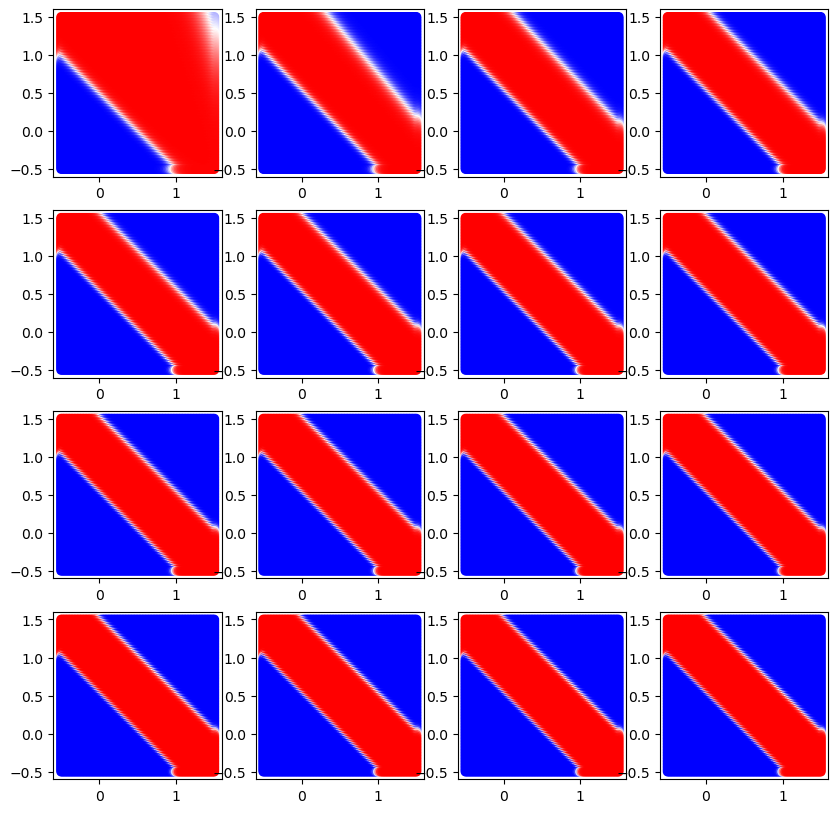

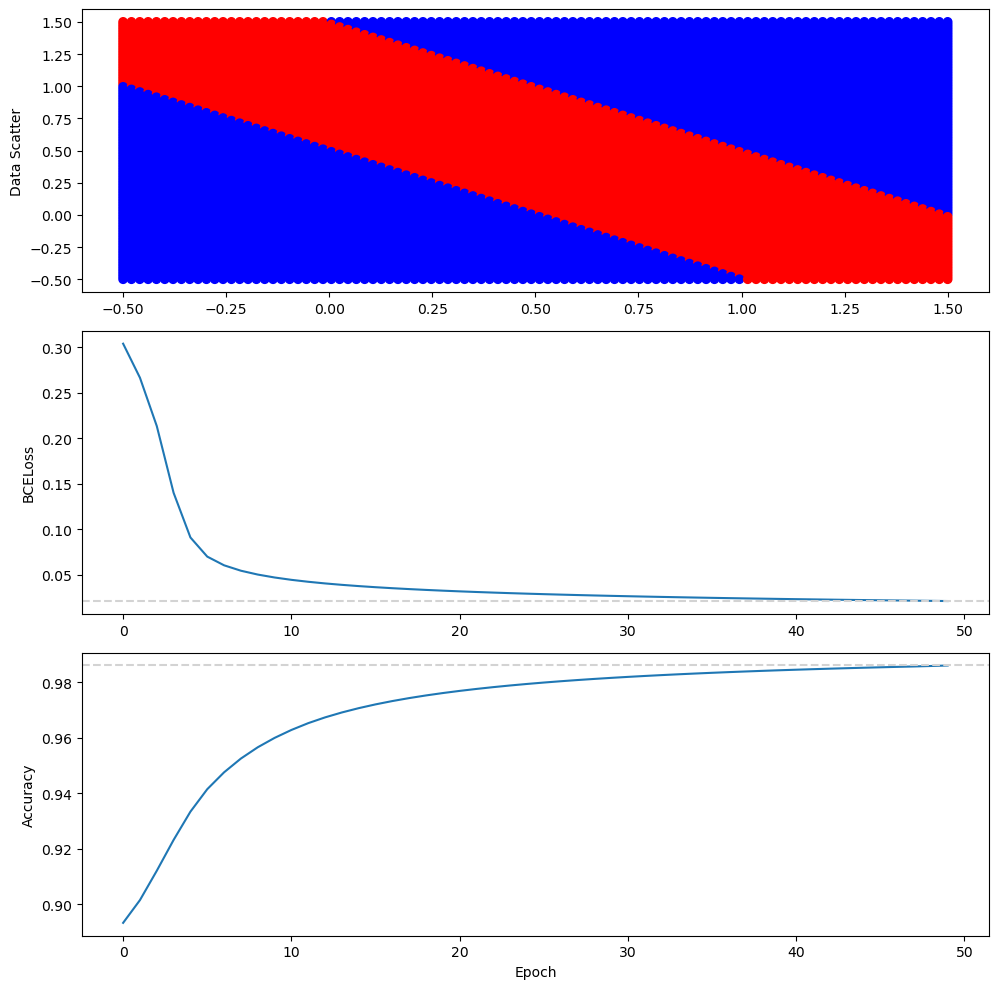

In [5]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 0
np.random.seed(SEED)
N_SAMPLES = 100
LR = 0.25
EPOCHS = 50
DRAW_FREQ = int(EPOCHS / 16)


# XOR 데이터 셋 생성. 개선 필요.
spot = np.linspace(-0.5, 1.5, N_SAMPLES)
x1, x2 = np.meshgrid(spot, spot)
# x2 = x2[::-1] # x2의 행순서 변경
x1, x2 = x1.flatten(), x2.flatten()
w_ = 0.5
y = []
for x1_, x2_ in zip(x1, x2): # XOR 라벨링
    z_ = w_*x1_ + w_*x2_
    if (z_ > 0.25) and (z_ < 0.75): y.append(1)
    else: y.append(0)
y = np.array(y) # 작업 편의성을 위해 np로 저장

# 모델 생성
m_nand = Model()
m_or = Model()
m_and = Model()
bce = BCELoss()

bcelosses = []
accuracies = []
threshold = 0.5
TP = 0
FN = 0
FP = 0
TN = 0

fig, axes = plt.subplots(4, 4, figsize=(10,10))
axes = axes.flatten()

for epoch in range(EPOCHS):
    epoch_loss = 0

    y_db = []
    for x1_, x2_, y_ in zip(x1, x2, y):
        # predict
        p1 = m_nand.forward(np.array([x1_, x2_]))
        p2 = m_or.forward(np.array([x1_, x2_]))
        pred = m_and.forward(np.array([p1, p2]))

        # BCELoss
        j = bce.forward(y_, pred)
        epoch_loss += j

        # Backpropagation
        dJ_dp = bce.backward()
        dJ_dw = m_and.backward(dJ_dp, LR)
        m_nand.backward(dJ_dw[0], LR)
        m_or.backward(dJ_dw[1], LR)
        
        # confusion matrix
        if (pred > threshold) and (y_ == 1): TP += 1
        elif (pred <= threshold) and (y_ == 1): FN += 1
        elif (pred > threshold) and (y_ == 0): FP += 1
        else: TN += 1

    if epoch % DRAW_FREQ == 0 and epoch > 1:
        y_db = []
        for x1_, x2_, y_ in zip(x1, x2, y):
            p1 = m_nand.forward(np.array([x1_, x2_]))
            p2 = m_or.forward(np.array([x1_, x2_]))
            pred = m_and.forward(np.array([p1, p2]))
            y_db.append(pred)
        axes[(epoch // DRAW_FREQ)-1].scatter(x1, x2, c=y_db, cmap='bwr')

    bcelosses.append(epoch_loss/(N_SAMPLES**2))
    accuracy = (TP + TN)/(TP + FN + FP + TN)
    accuracies.append(accuracy)

fig, axes = plt.subplots(3, 1, figsize=(10, 10))

axes[0].scatter(x1, x2, c=y, cmap='bwr')
axes[0].set_ylabel('Data Scatter')

axes[1].plot(bcelosses)
axes[1].set_ylabel('BCELoss')
axes[1].axhline(min(bcelosses), color='lightgray', linestyle='--')

axes[2].plot(accuracies)
axes[2].set_ylabel('Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].axhline(max(accuracies), color='lightgray', linestyle='--')
fig.tight_layout()